[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/081_euler/081_euler.ipynb)

$$
\begin{array}{c}
	\rho_t + \nabla \cdot (\rho u) = 0 \\
	(\rho \mathbf{u})_t + (\mathbf{u} \cdot \nabla)(\rho \mathbf{u}) + \nabla p = 0 \\
	(\rho e)_t + \nabla \cdot(\mathbf{u} (  \rho e + p )) = 0
\end{array}
$$

![](http://hypar.github.io/Solution_2DNavStokLowMachVortexPETSc.gif)

In [1]:
import math 
import torch 

# initial condition

GAMMA = 1.4
b = 5

x = torch.linspace(-5,5,50)
y = torch.linspace(-5,5,50)
xx, yy = torch.meshgrid(x,y)

r2 = xx**2 + yy**2
r0 = (1-(b*(GAMMA-1))/(8*math.pi*math.pi*GAMMA)*torch.exp(1-r2))**(1/(GAMMA-1))
u0 = 1 - b/(2*math.pi)*torch.exp(0.5*(1-r2))*y
v0 = b/(2*math.pi)*torch.exp(0.5*(1-r2))*x
p0 = r0**GAMMA

C:\Users\sensio\miniconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


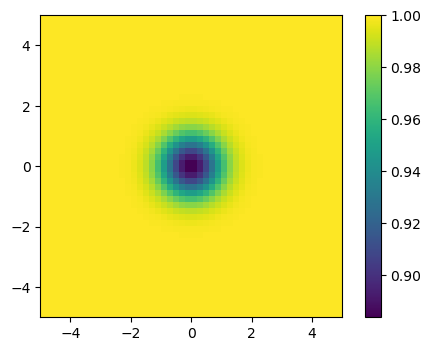

In [2]:
import matplotlib.pyplot as plt 

plt.figure(dpi=100)
plt.imshow(r0, vmin=r0.min(), vmax=r0.max(), origin='lower', extent=[-5, 5, -5 ,5])
plt.colorbar()
plt.show()

In [3]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

In [4]:
import torch.nn as nn

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

mlp = nn.Sequential(
    nn.Linear(3, 100),
    Sine(), 
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 4)
)

device = "cuda"

mlp.to(device)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
from fastprogress.fastprogress import progress_bar

N_STEPS = 100000
N_SAMPLES = 1000
N_SAMPLES_0 = 1000

optimizer = torch.optim.Adam(mlp.parameters())
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.4*N_STEPS), int(0.8*N_STEPS)], gamma=0.1)
criterion = torch.nn.MSELoss()
mlp.train()


mlp.to(device)

mb = progress_bar(range(1, N_STEPS+1))

for step in mb:

    # optimize for PDE
    x = torch.rand(N_SAMPLES, device=device)*10. - 5.
    y = torch.rand(N_SAMPLES, device=device)*10. - 5.
    t = torch.rand(N_SAMPLES, device=device)*10.

    X = torch.stack([  
        x, 
        y,
        t
    ], axis=-1)
    X.requires_grad = True
    
    y_hat = mlp(X) 
    r, u, v, p = y_hat[:,0], y_hat[:,1], y_hat[:,2], y_hat[:,3]
    
    grads = computeGrads(r, X)        
    drdt = grads[:, 2]

    grads = computeGrads(r*u, X)       
    drudx, drudt = grads[:, 0], grads[:, 2]

    grads = computeGrads(r*v, X)          
    drvdy, drvdt = grads[:, 1], grads[:, 2]

    grads = computeGrads(r*u*u + p, X)            
    druupdx = grads[:, 0]

    grads = computeGrads(r*u*v, X)              
    drvudx, druvdy = grads[:, 0], grads[:, 1]

    grads = computeGrads(r*v*v + p, X)            
    drvvpdy = grads[:, 1]

    re = p/(GAMMA-1) + 0.5*r*(u*u + v*v)
    grads = computeGrads(re, X)    
    dredt = grads[:, 2]

    grads = computeGrads((re+p)*u, X)   
    drepudx = grads[:, 0]

    grads = computeGrads((re+p)*v, X)   
    drepvdy = grads[:, 1]
        
    pde_loss = criterion(drdt, - drudx - drvdy) + \
        criterion(drudt, - druupdx - druvdy) + \
        criterion(drvdt, - drvudx - drvvpdy) + \
        criterion(dredt, - drepudx - drepvdy)
    
    # initial condition
    r2 = x**2 + y**2
    r00 = (1-(b*(GAMMA-1))/(8*math.pi*math.pi*GAMMA)*torch.exp(1-r2))**(1/(GAMMA-1))
    u = 1 - b/(2*math.pi)*torch.exp(0.5*(1-r2))*y
    v = b/(2*math.pi)*torch.exp(0.5*(1-r2))*x
    p = r00**GAMMA
    
    X = torch.stack([  
        x, 
        y,
        torch.zeros(N_SAMPLES, device=device)
    ], axis=-1)
    X.requires_grad = True
    y_hat = mlp(X) 
    ini_loss = criterion(y_hat, torch.stack([  
        r00,
        u, 
        v,
        p
    ], axis=-1))
    
    # optimize for boundary conditions
    # left
    Y0 = torch.stack([  
        -5.*torch.ones(N_SAMPLES_0, device=device), 
        y,
        t
    ], axis=-1)
    # right
    Y1 = torch.stack([  
        5.*torch.ones(N_SAMPLES_0, device=device), 
        y,
        t,
    ], axis=-1)
    y0 = mlp(Y0) 
    y1 = mlp(Y1) 
    y_loss = criterion(y0, y1)
    # bot
    X0 = torch.stack([
        x,
        -5.*torch.ones(N_SAMPLES_0, device=device), 
        t
    ], axis=-1)
    # right
    X1 = torch.stack([  
        x,
        5.*torch.ones(N_SAMPLES_0, device=device), 
        t,
    ], axis=-1)
    x0 = mlp(X0) 
    x1 = mlp(X1) 
    x_loss = criterion(x0, x1)

    bound_loss = y_loss + x_loss
         
    # update
    optimizer.zero_grad()
    loss = ini_loss + bound_loss + pde_loss 
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    mb.comment = f'pde_loss {pde_loss.item():.5f} ini_loss {ini_loss.item():.5f} bound_loss {bound_loss.item():.5f}'

In [ ]:
import numpy as np

def run_mlp(Nx, Ny, dt, tf):
    ps, ts = [], []
    t = 0
    x = np.linspace(-5,5,Nx)
    y = np.linspace(-5,5,Ny)
    X = np.stack(np.meshgrid(x,y), -1).reshape(-1, 2)
    X0 = torch.from_numpy(X).float()
    mlp.eval()
    mlp.cpu()
    while t < tf:
        with torch.no_grad():
            X = torch.cat([  # N, (X, Y, T)
                X0,
                torch.ones(len(X0)).unsqueeze(1)*t,
            ], axis=1)
            p = mlp(X)
        ps.append(p[:,0].reshape(Ny,Nx))
        ts.append(t)
        t += dt
    return ps, ts

In [ ]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update(i):
    r = ps[i]
    ax.clear()
    ax.imshow(r, vmin=0.9, vmax=1., origin='lower', extent=[-5, 5, -5 ,5])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f't = {ts[i]:.3f}')
    ax.axis('off')
    return ax

In [ ]:

ps, ts = run_mlp(33, 33, 0.2, 10)

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim